## Setup

In [66]:
import yaml
from pathlib import Path

import torch
import numpy as np

import pyFM
from project.datasets import Tosca
from project.train_dpfm import train_net
from project.eval_dpfm import eval_net

In [172]:
data_path = "../.."
cfg = yaml.safe_load(open(f"dpfm/config/tosca_cuts.yaml", "r"))
cfg["dataset"]["root_train"] = cfg["dataset"]["root_train"].replace("{{ABS_PATH}}", data_path)
cfg["dataset"]["root_test"] = cfg["dataset"]["root_test"].replace("{{ABS_PATH}}", data_path)
cfg["dataset"]["cache_dir"] = cfg["dataset"]["cache_dir"].replace("{{ABS_PATH}}", data_path)

In [164]:
import numpy as np
import meshplot as mp
import matplotlib.pyplot as plt
%matplotlib inline

def plot_mesh(myMesh,cmap=None):
    mp.plot(myMesh.vertlist, myMesh.facelist,c=cmap)
    
def double_plot(myMesh1,myMesh2,cmap1=None,cmap2=None):
    d = mp.subplot(myMesh1.vertlist, myMesh1.facelist, c=cmap1, s=[2, 2, 0])
    mp.subplot(myMesh2.vertlist, myMesh2.facelist, c=cmap2, s=[2, 2, 1], data=d)

def visu(vertices):
    min_coord,max_coord = np.min(vertices,axis=0,keepdims=True),np.max(vertices,axis=0,keepdims=True)
    cmap = (vertices-min_coord)/(max_coord-min_coord)
    return cmap

def plot_p2p(mesh1, mesh2, p2p):
    cmap1 = visu(mesh1.vertlist); cmap2 = cmap1[p2p]
    double_plot(mesh1,mesh2,cmap1,cmap2)

def plot_geod_err(dist_dict, save_dir=None):
    for name, dist in dist_dict.items():
        N = len(dist)
        # sort the data in ascending order
        x = np.sort(dist)
        # get the cdf values of y
        y = np.arange(N) / float(N)
        plt.plot(x, y, label=name)
    plt.legend()
    plt.xlim([0.0, 0.06])
    plt.title("Comparison of different methods")
    plt.xlabel("Geodesic error")
    plt.ylabel("% of correspondences")
    if save_dir:
        plt.savefig(save_dir)

In [29]:
test_dataset = Tosca(cfg["dataset"]["root_test"], name=cfg["dataset"]["subset"], k_eig=cfg["fmap"]["k_eig"],
                                           n_fmap=cfg["fmap"]["n_fmap"], use_cache=True, op_cache_dir=cfg["dataset"]["cache_dir"], use_adj=True)

using dataset cache path: ../../data/SGP_dataset_off/test_full/cache_cuts_train.pt
  --> loading dataset from cache


In [72]:
test_dev_dataset = Tosca('../../data/SGP_dataset_off/test_dev', name=cfg["dataset"]["subset"], k_eig=cfg["fmap"]["k_eig"],
                                           n_fmap=cfg["fmap"]["n_fmap"], use_cache=True, op_cache_dir=cfg["dataset"]["cache_dir"], use_adj=True)

using dataset cache path: ../../data/SGP_dataset_off/test_dev/cache_cuts_train.pt
  --> loading dataset from cache


# Evaluation of models

There are two methods of evaluating the results of a model.
1. Use the files generated during the evaluation run, which are saved in the given path
2. Set the return arguments of the evaluation functions 'run_eval' to true and use the return values

##  1. Method: Load saved evaluation files

The first shorthand in the file name (fm/cfm) shows, whether the descriptors were evaluated with functional maps or coupled functional maps.
The second shorthand shows the model that was used:
- base: pretrained Shrec model
- dpfm: standart DPFM model trained on TOSCA data
- pt: DPFM model trained on TOSCA, but the overlap predictor and cross attention layers were initialized with the pretrained Shrec model
- dpcfm: DPCFM model trainedd on TOSCA

In [179]:
folder_path = Path("data/eval")

fm_base_file_path = folder_path / "fm_base.pt"
cfm_base_file_path = folder_path / "cfm_base.pt"
fm_pt_file_path = folder_path / "fm_pt.pt"
cfm_pt_file_path = folder_path / "cfm_pt.pt"
fm_dpfm_file_path = folder_path / "fm_dpfm.pt"
cfm_dpfm_file_path = folder_path / "cfm_dpfm.pt"
fm_dpcfm_file_path = folder_path / "fm_dpcfm.pt"
cfm_dpcfm_file_path = folder_path / "cfm_dpcfm.pt"

fm_base_eval = torch.load(fm_base_file_path)
cfm_base_eval = torch.load(cfm_base_file_path)
fm_pt_eval = torch.load(fm_pt_file_path)
cfm_pt_eval = torch.load(cfm_pt_file_path)
fm_dpfm_eval = torch.load(fm_dpfm_file_path)
cfm_dpfm_eval = torch.load(cfm_dpfm_file_path)
fm_dpcfm_eval = torch.load(fm_dpcfm_file_path)
cfm_dpcfm_eval = torch.load(cfm_dpcfm_file_path)

### Example

In [60]:
i = 1

In [61]:
fm_log_obj = fm_base_eval["log_obj"][i]
cfm_log_obj = cfm_base_eval["log_obj"][i]
data = test_dataset[i]

In [64]:
plot_p2p(data["shape1"]["mesh"], data["shape2"]["mesh"], fm_log_obj[5])

In [65]:
A_geod = data["shape1"]["mesh"].get_geodesic(verbose=True)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [67]:
acc = pyFM.eval.accuracy(fm_log_obj[5], fm_log_obj[6], A_geod, sqrt_area=data["shape1"]["mesh"].sqrtarea)

In [69]:
acc

0.5613517385790701

## 2. Method: Evaluate networks

In [174]:
cfg["dataset"]["root_test"] = '../../data/SGP_dataset_off/test_dev'

In [106]:
p2p_fm_pt, distances_fm_pt = eval_net(cfg, "project/models/dpfm_pt.pth", "data/eval/fm_pt.pt", return_pred_p2p=True, return_dist=True, mode="FM")

Starting evaluation...
Using device cpu
Loading data...
using dataset cache path: ../../data/SGP_dataset_off/test_dev/cache_cuts_train.pt
  --> loading dataset from cache
Loading model...
Starting inference...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [03:27<00:00, 34.62s/it]


Mean normalized geodesic error: 0.02577751704120111


In [175]:
p2p_cfm_pt, distances_cfm_pt = eval_net(cfg, "project/models/dpfm_pt.pth", "data/eval/cfm_pt.pt", return_pred_p2p=True, return_dist=True, mode="CFM")

Starting evaluation...
Using device cpu
Loading data...
using dataset cache path: ../../data/SGP_dataset_off/test_dev/cache_cuts_train.pt
  --> loading dataset from cache
Loading model...
Starting inference...


  0%|                                                                                                                               | 0/6 [00:00<?, ?it/s]

nit:7703


 17%|███████████████████▊                                                                                                   | 1/6 [00:55<04:38, 55.67s/it]

nit:9590


 33%|███████████████████████████████████████▋                                                                               | 2/6 [01:52<03:44, 56.18s/it]

nit:7252


 50%|███████████████████████████████████████████████████████████▌                                                           | 3/6 [02:43<02:41, 53.74s/it]

nit:2069


 67%|███████████████████████████████████████████████████████████████████████████████▎                                       | 4/6 [03:28<01:40, 50.48s/it]

nit:6338


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 5/6 [04:19<00:50, 50.53s/it]

nit:8132


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [05:09<00:00, 51.64s/it]


Mean normalized geodesic error: 0.024909314934781292


In [90]:
i=5
plot_p2p(p2p_fm_pt[i]["mesh1"], p2p_fm_pt[i]["mesh2"], p2p_fm_pt[i]["p2p"])

In [176]:
p2p_cfm_dpcfm, distances_cfm_dpcfm = eval_net(cfg, "project/models/dpcfm.pth", "data/eval/cfm_dpcfm.pt", return_pred_p2p=True, return_dist=True, mode="CFM")

Starting evaluation...
Using device cpu
Loading data...
using dataset cache path: ../../data/SGP_dataset_off/test_dev/cache_cuts_train.pt
  --> loading dataset from cache
Loading model...
Starting inference...


  0%|                                                                                                                               | 0/6 [00:00<?, ?it/s]

nit:3314


 17%|███████████████████▊                                                                                                   | 1/6 [00:41<03:28, 41.72s/it]

nit:12092


 33%|███████████████████████████████████████▋                                                                               | 2/6 [01:49<03:47, 56.81s/it]

nit:3022


 50%|███████████████████████████████████████████████████████████▌                                                           | 3/6 [02:37<02:39, 53.00s/it]

nit:2193


 67%|███████████████████████████████████████████████████████████████████████████████▎                                       | 4/6 [03:17<01:35, 47.68s/it]

nit:8834


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 5/6 [04:14<00:51, 51.25s/it]

nit:4022


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [04:52<00:00, 48.72s/it]


Mean normalized geodesic error: 0.028143958880872327


In [109]:
p2p_fm_dpcfm, distances_fm_dpcfm = eval_net(cfg, "project/models/dpcfm.pth", "data/eval/fm_dpcfm.pt", return_pred_p2p=True, return_dist=True, mode="FM")

Starting evaluation...
Using device cpu
Loading data...
using dataset cache path: ../../data/SGP_dataset_off/test_dev/cache_cuts_train.pt
  --> loading dataset from cache
Loading model...
Starting inference...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [03:23<00:00, 33.84s/it]


Mean normalized geodesic error: 0.018031737062125144


In [92]:
i=5
plot_p2p(p2p_fm_dpcfm[i]["mesh1"], p2p_fm_dpcfm[i]["mesh2"], p2p_fm_dpcfm[i]["p2p"])

/opt/anaconda3/envs/shape_correspondence/lib/python3.9/site-packages/jupyter_client/session.py:716: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


In [110]:
p2p_fm_dpfm, distances_fm_dpfm = eval_net(cfg, "project/models/dpfm.pth", "data/eval/fm_dpfm.pt", return_pred_p2p=True, return_dist=True, mode="FM")

Starting evaluation...
Using device cpu
Loading data...
using dataset cache path: ../../data/SGP_dataset_off/test_dev/cache_cuts_train.pt
  --> loading dataset from cache
Loading model...
Starting inference...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [03:15<00:00, 32.55s/it]


Mean normalized geodesic error: 0.015997255936707994


In [177]:
p2p_cfm_dpfm, distances_cfm_dpfm = eval_net(cfg, "project/models/dpfm.pth", "data/eval/cfm_dpfm.pt", return_pred_p2p=True, return_dist=True, mode="CFM")

Starting evaluation...
Using device cpu
Loading data...
using dataset cache path: ../../data/SGP_dataset_off/test_dev/cache_cuts_train.pt
  --> loading dataset from cache
Loading model...
Starting inference...


  0%|                                                                                                                               | 0/6 [00:00<?, ?it/s]

nit:4731


 17%|███████████████████▊                                                                                                   | 1/6 [00:46<03:54, 46.87s/it]

nit:6266


 33%|███████████████████████████████████████▋                                                                               | 2/6 [01:35<03:11, 47.90s/it]

nit:2537


 50%|███████████████████████████████████████████████████████████▌                                                           | 3/6 [02:18<02:16, 45.57s/it]

nit:1829


 67%|███████████████████████████████████████████████████████████████████████████████▎                                       | 4/6 [02:52<01:22, 41.23s/it]

nit:4914


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 5/6 [03:37<00:42, 42.41s/it]

nit:3136


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [04:22<00:00, 43.76s/it]


Mean normalized geodesic error: 0.017627504884188756


In [112]:
p2p_fm_base, distances_fm_base = eval_net(cfg, "project/data/shrec_pretrained_model/shrec_cuts.pth", "data/eval/fm_base.pt", return_pred_p2p=True, return_dist=True, mode="FM")

Starting evaluation...
Using device cpu
Loading data...
using dataset cache path: ../../data/SGP_dataset_off/test_dev/cache_cuts_train.pt
  --> loading dataset from cache
Loading model...
Starting inference...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [03:34<00:00, 35.83s/it]


Mean normalized geodesic error: 0.26372879629866147


In [178]:
p2p_cfm_base, distances_cfm_base = eval_net(cfg, "project/data/shrec_pretrained_model/shrec_cuts.pth", "data/eval/cfm_base.pt", return_pred_p2p=True, return_dist=True, mode="CFM")

Starting evaluation...
Using device cpu
Loading data...
using dataset cache path: ../../data/SGP_dataset_off/test_dev/cache_cuts_train.pt
  --> loading dataset from cache
Loading model...
Starting inference...


  0%|                                                                                                                               | 0/6 [00:00<?, ?it/s]

nit:13769


 17%|███████████████████▊                                                                                                   | 1/6 [01:24<07:01, 84.32s/it]

nit:14118


 33%|███████████████████████████████████████▋                                                                               | 2/6 [02:37<05:11, 77.92s/it]

nit:14123


 50%|███████████████████████████████████████████████████████████▌                                                           | 3/6 [04:06<04:08, 82.81s/it]

nit:5416


 67%|███████████████████████████████████████████████████████████████████████████████▎                                       | 4/6 [05:00<02:23, 71.60s/it]

nit:14056


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 5/6 [06:06<01:09, 69.48s/it]

nit:12256


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [07:08<00:00, 71.46s/it]


Mean normalized geodesic error: 0.18279729654884025


### Accum. geodesic error plot

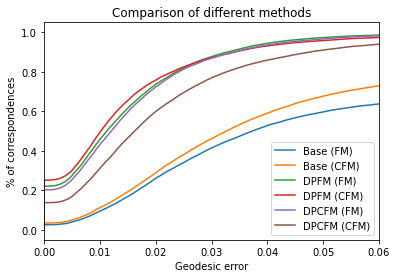

In [186]:
dist_dict = {
    'Base (FM)': distances_fm_base,
    'Base (CFM)': distances_cfm_base,
    'DPFM (FM)': distances_fm_dpfm,
    'DPFM (CFM)': distances_cfm_dpfm,
    'DPCFM (FM)': distances_fm_dpcfm,
    'DPCFM (CFM)': distances_cfm_dpcfm,
    #'fm_pt': distances_fm_pt,
    #'cfm_pt': distances_cfm_pt,
}

save_dir = "data/eval/dpcfm_ge.png"

plot_geod_err(dist_dict, save_dir)

In [146]:
i=0
plot_p2p(p2p_cfm_dpcfm[i]["mesh1"], p2p_cfm_dpcfm[i]["mesh2"], p2p_cfm_dpcfm[i]["p2p"])